# Verification of Neural Networks via Linear Programming
<sup>author: [Daniel S. Fava](http://www.danielfava.com)</sup><br/>
License: CC BY 4.0
https://creativecommons.org/licenses/by/4.0/

Below we explain how to check the robustness of a neural network and how to systematically create [adversarial examples](https://blog.openai.com/adversarial-example-research/) using linear programming.  An adversarial image is an image that is altered just enough for a neural network to misclassify it.  The original image and the altered (adversarial) one are indistinguishable to the human eye.

The goal of the presentation below is to be simple yet precise.  It is meant to illustrate a technique rather than to provide a practical implementation.  We will proceed as follows:

1. First, we define a training set of 2x2 images, then
1. train a neural network with [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function,
1. compute a logic formula in disjunctive-normal-form (DNF) that captures the behavior of the neural-network,
1. pick an image that is correctly classified and then solve a system of linear equalities/inequalities for each clause of the DNF.  If the linear system has a solution, the solution will be an adversarial example.

You can experiment with the source code (Python3 jupyter notebook) as you follow along.

In [1]:
from nn import get_layer_sizes
from nn import draw_neural_net
from nn import nn_to_formula_components
from nn import formula_components_to_dnf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier # multi-layer perceptron (MLP)

# Training the neural network

### Defining a training set
One way to make things simple is to have a simple domain and a small training set.  We pick 2x2 images in grayscale as the domain.  The 16 images below are the training set.  Images are labeled as 1 and highlighted in red when their bottom row contains only black pixels.  They are labeled as 0 otherwise.

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


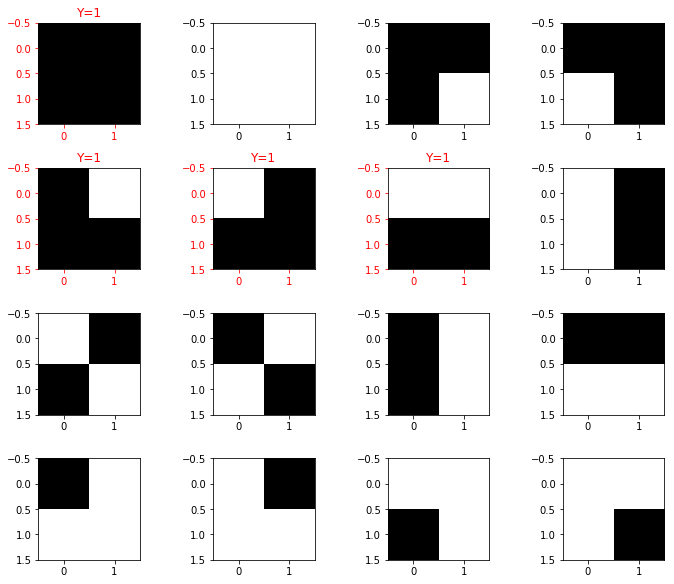

In [2]:
# Training set
X_img = [
     [[0, 0],     [0, 0]],
     [[255, 255], [255, 255]],
     [[0, 0],     [0, 255]],
     [[0, 0],     [255, 0]],
     [[0, 255],   [0, 0]],
     [[255, 0],   [0, 0]],
     [[255, 255], [0, 0]],
     [[255, 0],   [255, 0]],
     [[255, 0],   [0, 255]],
     [[0, 255],   [255,0]],
     [[0, 255],   [0,255]],
     [[0, 0],     [255,255]],
     [[0, 255],   [255,255]],
     [[255, 0],   [255,255]],
     [[255, 255], [0,255]],
     [[255, 255], [255,0]],  
    ]
y = [1 if img[1][0] <= 50 and img[1][1] <= 50 else 0 for img in X_img]
print(y)

# Gray scale from black (0) to white (255)
norm = norm=matplotlib.colors.NoNorm(vmin=0, vmax=255, clip=True)

fig = plt.figure(figsize=(10,10))
for idx,img in enumerate(X_img):
    if (idx > 15): break
    arr = np.array(img)
    ax = plt.subplot(5,4,idx+1)
    plt.imshow(arr, cmap='gray', norm=norm)
    if y[idx]:
        ax.set_title("Y=1", color='red')
        ax.tick_params(axis='x', colors='red')
        ax.tick_params(axis='y', colors='red')     
fig.tight_layout()
plt.show()

### Training the neural network
We train a very small neural network composed of 3 neurons: 2 at the input layer and one at the output.
The technique works on larger networks, thought there is an exponential cost on the number of neurons (more on that later).  The technique does require [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) as the activation function, this will be clearer when we discuss how to turn the neural network into a logic formula.

In [3]:
# Defining the neural network
hidden_layer_sizes = (2,)
clf = MLPClassifier(
            solver='lbfgs',    # solver used when training
            alpha=1e-5,        # L2 penalty (regularization term) parameter
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=1,    # If int, it's the seed of the random number gen.
            activation="relu") # activation function
# Turing images into vector
X = [[float(item) for item in np.concatenate(img)] for img in X_img]
# Train the neural network
clf.fit(X, y)
print(clf)
print("Layers", clf.n_layers_)
print("Coefs", clf.coefs_)
print("Intercepts", clf.intercepts_)
print("n inter", clf.n_iter_)
print("loss", clf.loss_)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
Layers 3
Coefs [array([[-0.16546093, -0.4507274 ],
       [-0.99678884, -0.38952316],
       [-0.7043807 , -0.81289063],
       [-0.62560775, -1.2026514 ]]), array([[-0.22787063],
       [ 1.75462163]])]
Intercepts [array([-0.20646505,  6.43405911]), array([-1.38663425])]
n inter 25
loss 0.46913275221449097


[4, 2, 1]


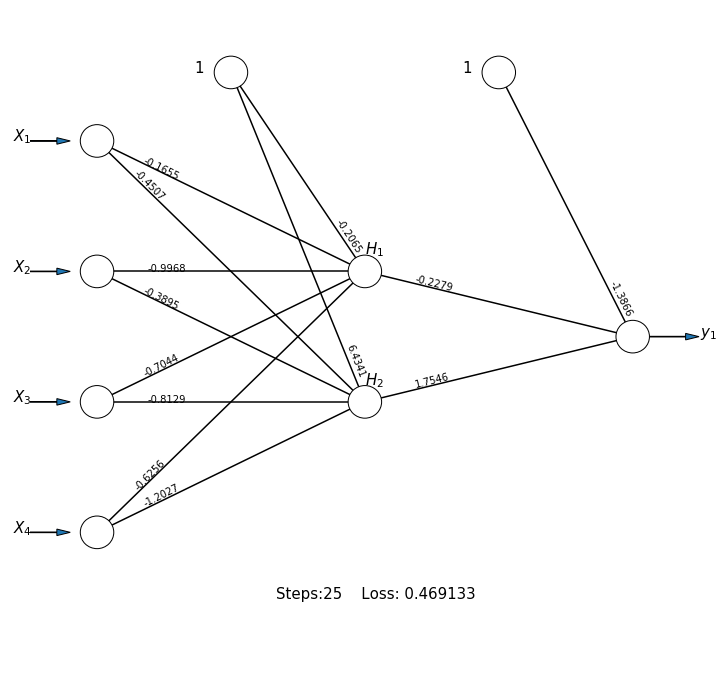

In [4]:
# Draw the neural network
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
layer_sizes = get_layer_sizes(clf.coefs_, clf.intercepts_)
print(layer_sizes)
draw_neural_net(ax, .1, .9, .1, .9,
    clf.coefs_,
    clf.intercepts_,
    clf.n_iter_,
    clf.loss_)

# From neural network to logic formula

At this point, we can print the linear part of each neuron, that is, before activation function.  It is simply the multiplication of its inputs by its weights.

In [6]:
formula_components = nn_to_formula_components(clf.coefs_, clf.intercepts_)
print("Linear part of each neuron, that is, before activation function:")
for (var,val) in formula_components:
    print("%s = %s" % (var,val))

Linear part of each neuron, that is, before activation function:
Y0_0 = X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065
Y0_1 = X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341
Y1_0 = Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866


The output of one neuron is the application of [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) to the dot-product of the neuron's weights and the neuron's inputs.


$ y = ReLU(\mathbf{w} . \mathbf{x}) = max(0, \mathbf{w} . \mathbf{x}) $

The operation of the neuron can then be expressed as a logic formula:

\begin{align*}
( y == \mathbf{w} . \mathbf{x} \land y > 0) \\
\lor ( y == 0 \land \mathbf{w} . \mathbf{x} \leq 0)
\end{align*}

There will be one such logical formula per neuron.
The operation of the neural network is the conjunction of all these formulas.  **If we distribute the terms over the conjunctions, we will end up with a formula in DNF-form.**  Note that there will be 2<sup>n</sup> clauses in the DNF formula, where n are the number of neurons.  This is the exponential blow-up we mentioned earlier.

In [7]:
dnf_formula = formula_components_to_dnf(formula_components)
print("DNF formula for neural network:")
for clause in dnf_formula:
    for term in clause:
        print(term)
    print()

DNF formula for neural network:
Y0_0 == 0
X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065 <= 0
Y0_1 == 0
X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341 <= 0
Y1_0 == 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0

Y0_0 == X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065
Y0_0 > 0
Y0_1 == 0
X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341 <= 0
Y1_0 == 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0

Y0_0 == 0
X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065 <= 0
Y0_1 == X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341
Y0_1 > 0
Y1_0 == 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0

Y0_0 == X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065
Y0_0 > 0
Y0_1 == X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341
Y0_1 > 0
Y1_0 == 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0

Y0_0 == 0
X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065 <= 0
Y0_1 == 0
X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341 <= 0
Y1_

# Crafting an adversarial image

**(Observation 1) Each of the clauses in the DNF formula is disjoint from one another; meaning, only one of them is "true" at a time.**

**(Observation 2) Each clause in the DNF formula covers a convex region of the input space.  This convex region is determined by a system of linear relations.**  

We will use observation 1 and 2 to craft an adversarial image as follows:
Starting with an image ```i``` such that ```n(i)=1```, meaning, the output of the neural network ```n``` on ```i``` is 1.
For each convex region whose output is 0 check if the input image ```i+d``` is in its preimage, where ```d``` is a small delta.  Since each convex region is defined by a system of linear relations, the check can be performed using linear programming.

### Starting image

Let us start with the following 2x2 image that is classified as 1:

Vector  [0.0, 0.0, 0.0, 0.0]
Pred.   [1]



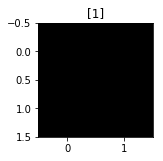

In [8]:
ori_img = [[0,0],[0,0]]
imgs = [ori_img]
predictions = []
for img in imgs:
    vec = [float(item) for item in np.concatenate(img)]
    pred = clf.predict([vec])
    print("Vector ", vec)
    print("Pred.  ", pred)
    print()
    predictions.append(pred)

fig = plt.figure(figsize=(10,10))
for idx,img in enumerate(imgs):
    if (idx > 15): break
    arr = np.array(img)
    ax = plt.subplot(5,4,idx+1)
    ax.set_title(predictions[idx])
    plt.imshow(arr, cmap='gray', norm=norm)
fig.tight_layout()
plt.show()

### Formulating the delta

We will add a constraint saying that the new image that is the old image with a delta added to each of its pixels.  Since the original image was all black (all its pixel values are 0), the constraint looks like this:

In [9]:
in_img_str = ["X%d==%f + D%d" % (idx,val,idx) for idx,val in enumerate(np.concatenate(ori_img))]
print(in_img_str)

['X0==0.000000 + D0', 'X1==0.000000 + D1', 'X2==0.000000 + D2', 'X3==0.000000 + D3']


### Going over the DNF clauses
There are 2<sup>n</sup> clauses in the DNF formula, where n are the number of neurons.  
Half of them are true when the output neuron fires and the other half are true when it does not.  Our neural network has 3 neurons, so there are 8 clauses in its DNF formula, 4 of these clauses classify images with label 0.  Since we are starting with an image whose label is 1 and we are looking for an adversarial image similar to the starting image but whose classification is 0, we need to evaluate four of the DNF clauses.

Let's start with this clause here:

```
Y0_0 == 0
X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065 <= 0
Y0_1 == X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341
Y0_1 > 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0
Y0_0 == 0
```

### Framing the problem in terms of linear programming
A clause of the DNF representing our neural network is nothing more than a system of linear equalities and inequalities.
We'll use the LP solver from [SciPi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html), which expects the problem to be framed as:

```
Minimize:     c^T * x

Subject to:   A_ub * x <= b_ub
              A_eq * x == b_eq
```

In our case, ```x``` is:

```
x = [X0, X1, X2, X3, Y0_0, Y0_1, Y1_0, D0, D1, D2, D3]
```

We want to minimize the sum of the deltas ``D0 + D1 + D2 + D3```
subject to the linear constraints:

```
Y0_0 == 0
Y0_1 == X0*-0.4507 + X1*-0.3895 + X2*-0.8129 + X3*-1.2027 + 6.4341
Y0_0 == 0
```
and inequality constraints:
```
X0*-0.1655 + X1*-0.9968 + X2*-0.7044 + X3*-0.6256 + -0.2065 <= 0
Y0_1 > 0
Y0_0*-0.2279 + Y0_1*1.7546 + -1.3866 <= 0
```

We can also limit the ranges of pixel values to between 0 and 255, or put hard limits on the deltas:

```
0 <= X0, X1, X2, X3 <= 255
-3 <= D0, D1, D2, D3 <= 3
```

This yields the following system, whose solution is presented below.

In [10]:
from scipy.optimize import linprog

c = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
A_ub = [
    [-0.1655, -0.9968, -0.7044, -0.6256, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, -0.2279, 1.7546, 0, 0, 0, 0, 0]
]
b_ub = [0.2065, 1.3866]
A_eq = [
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0.4507, 0.3895, 0.8129, 1.2027, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, -1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1]
]
b_eq = [0, 6.4341, 0, 0, 0, 0]
x_bounds = (0, 255)
y_bounds = (None, None)
d_bounds = (0, 3)
bounds = [
    x_bounds, x_bounds, x_bounds, x_bounds, # X0, X1, X2, X3
    (None,None), # Y0_0, There is already an equation for Y0_0==0
    (0,None),    # Y0_1, Y0_1 > 0 from system of linear equations
    (None,0),    # Y1_0, Y1_0 < 0 for misclassification
    d_bounds, d_bounds, d_bounds, d_bounds, # D0, D1, D2, D3
]
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, options={"disp": True})
print(res)

Optimization terminated successfully.
         Current function value: 5.504286    
         Iterations: 8
     fun: 5.504286397344922
 message: 'Optimization terminated successfully.'
     nit: 8
   slack: array([  3.84731934,   0.        , 255.        , 255.        ,
       252.4957136 , 252.        ,   0.        ,   3.        ,
         3.        ,   0.4957136 ,   0.        ])
  status: 0
 success: True
       x: array([0.        , 0.        , 2.5042864 , 3.        , 0.        ,
       0.79026559, 0.        , 0.        , 0.        , 2.5042864 ,
       3.        ])


### Interpreting the solution
The LP solver was able to find the minimal ```D0+D1+D2+D3``` that,
when added to the image ```[0,0,0,0]``` causes its classification to change from ```1``` to ```0```.


It found a ```D0+D1+D2+D3``` equal to ```5.504```, in other words,
there is no smaller delta that can cause a misclassification.
**This value gives us a notion of how robust the neural network is (given the starting input image).**

The LP solver also gives us the adversarial image.
By how the problem was formulated we have ```x=[X0,X1,X2,X3,...]```
thus, we have the adversarial image in the first 4 elements of the ```x``` vector.  In our case, it is ```[0, 0, 2.504, 3]```.

#### Checking the result

Below we show how input images ```[0,0,0,0]``` to ```[0,0,2,2]``` are classified as ```1```,
but that the input image ```[0,0,3,3]``` is classified as ```0```.

We can think of ```[0,0,3,3]``` as an "adversarial image" to our original image ```[0,0,0,0]```.  It represents a discontinuity: a small delta on added to the original image causes a "large" delta on the output label.

Vector  [0.0, 0.0, 0.0, 0.0]
Label   1
Pred.   [1]



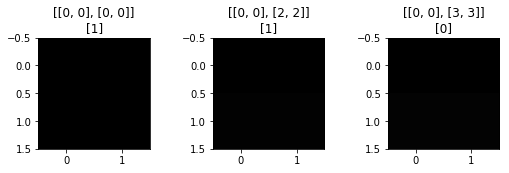

In [11]:
for idx,vec in enumerate(X):
    pred = clf.predict([vec])
    if pred == 1:
        print("Vector ", vec)
        print("Label  ", y[idx])
        print("Pred.  ", pred)
        print()
test_set = [
    [[0,0],[0,0]],
    [[0,0],[2,2]],
    [[0,0],[3,3]],    
]
predictions = []
for img in test_set:
    vec = [float(item) for item in np.concatenate(img)]
    pred = clf.predict([vec])
    predictions.append(pred)

fig = plt.figure(figsize=(10,10))
for idx,img in enumerate(test_set):
    if (idx > 15):
        break
    arr = np.array(img)
    ax = plt.subplot(5,4,idx+1)
    ax.set_title("%s\n%s" % (img, predictions[idx]))
    plt.imshow(arr, cmap='gray', norm=norm)
fig.tight_layout()
plt.show()

# Summary
We walked through an example showing how to check the robustness of a neural network and how to systematically create adversarial examples in Python using linear programming.
The worst case runtime for the technique is very poor, and would not scale well to complex neural networks.  However, with more engineering, we can achieve better performance on average.
One idea, described [here](https://arxiv.org/pdf/1702.01135), is to extend simplex in order to handle ReLU.